In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.linear_model import LogisticRegression  # Regressão Logística.
from sklearn.svm import SVC                          # Máquinas de Vetores de Suporte (SVM).
from sklearn.neighbors import KNeighborsClassifier   # K-Vizinhos Mais Próximos
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [21]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Frenagem'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Frenagem
0,1393.304461,1339.523445,1200.000000,568.132661,1898.902413,550.000000,69.725413,139.027996,0.380331,0.593223,...,NaN,NaN,NaN,NaN,NaN,NaN,42.139486,NaN,NaN,1
1,1447.028832,1330.136525,1361.481906,1505.363554,2079.855119,374.265277,74.859956,94.351698,0.411191,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1360.497021,1300.548245,1229.410830,2034.755114,2073.610993,525.174720,79.479623,98.184666,0.414025,0.562029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1375.720704,1285.067917,1267.613713,2238.367796,2017.352229,451.574651,65.639500,86.142680,0.416392,0.510369,...,NaN,NaN,3.899899,2.011436,3.056203,58.0,55.922387,7.163712,7.754569,1
4,1412.899313,1318.765014,1200.000000,1449.569054,2065.365531,534.234474,78.846482,115.531577,0.388342,0.522544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [22]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DP_Altura do CG com relacao ao chao',
    'DMV_Lado Direito',
    'ST_Curso Positivo de projeto',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [6]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   MV_Eixo dianteiro                                        1000 non-null   float64
 1   MV_Eixo Traseiro                                         1000 non-null   float64
 2   DMV_Dianteira                                            1000 non-null   float64
 3   PCG_X                                                    1000 non-null   float64
 4   PCG_Y                                                    1000 non-null   float64
 5   PCG_Z                                                    1000 non-null   float64
 6   SD_Dimensoes dos pneus                                   1000 non-null   int64  
 7   SD_Cambagem estatica                                     836 non-null    float64
 8   SD_Convergência estatica     

In [7]:
#Descrição de dados
df.describe()

,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Dimensoes dos pneus,SD_Cambagem estatica,SD_Convergência estatica,ST_Dimensoes dos pneus,...,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Frenagem
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,836.000000,754.000000,1000.000000,...,1000.000000,950.000000,894.000000,190.000000,246.000000,361.000000,239.000000,269.000000,203.000000,1000.000000
mean,77.448493,106.433733,0.420762,141.757429,23.202524,202.828145,20.276000,-0.234701,0.022792,20.307000,...,19.266226,28.827945,6.225256,4.866361,6.659909,48.491226,44.256078,9.574897,11.213208,3.000000
std,9.565263,13.577921,0.024451,134.027494,62.550087,113.917266,6.082172,0.576418,0.379799,6.083565,...,1.101338,4.632270,1.162893,1.097647,1.621433,4.300584,4.974943,4.240123,5.053376,1.414921
min,54.078316,75.323941,0.338735,-263.462383,-105.459839,0.513161,0.000000,-3.764598,-1.934054,0.000000,...,13.878079,3.283746,0.712082,2.177447,2.540235,40.202674,30.130178,4.361463,4.619092,1.000000
25%,70.714219,96.804347,0.404308,72.545840,-4.000000,142.540444,21.000000,-0.255998,0.000000,21.000000,...,18.674450,26.930874,5.478148,4.192360,5.674035,45.293904,40.399058,7.147603,8.624562,2.000000
50%,76.406716,105.973041,0.418524,108.540723,3.928465,196.725720,22.000000,0.000000,0.000000,22.000000,...,18.988267,28.465690,6.232617,4.877446,6.919985,48.025387,43.402995,8.856974,10.471005,3.000000
75%,82.445708,114.476116,0.435471,156.259205,38.619801,244.160580,23.000000,0.000000,0.000000,23.000000,...,19.850367,31.520644,6.930703,5.538014,7.979326,51.605104,46.986548,10.635829,12.232718,4.000000
max,115.618182,172.880844,0.482233,703.179912,304.243624,955.838229,23.000000,1.999325,1.422454,23.000000,...,23.000000,40.539802,9.813853,7.270000,9.629296,62.823866,62.184199,30.955267,32.977558,5.000000


In [10]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.")    

'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 10.
'PCG_Z' tem 0.
'SD_Dimensoes dos pneus' tem 81.
'SD_Cambagem estatica' tem 572.
'SD_Convergência estatica' tem 547.
'ST_Dimensoes dos pneus' tem 81.
'ST_Cambagem estatica' tem 613.
'ST_Convergência estatica' tem 565.
'FD_Pressao no sistema a 07g ' tem 0.
'FD_Forca no pedal a 07g ' tem 0.
'FD_Curso total do pedal ' tem 0.
'FD_Diametro do disco ' tem 0.
'FT_Pressao no sistema a 07g ' tem 0.
'FT_Diametro do disco ' tem 0.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Distancia de frenagem de 35 a 0 em asfalto' tem 0.
'CD_Distancia de frenagem de 35 a 0 em terra batida' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' tem 0.
'CD_Tempo para atingir velocidade maxi

## Limpeza

In [23]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 805 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

MV_Eixo dianteiro                                            0
MV_Eixo Traseiro                                             0
DMV_Dianteira                                                0
PCG_X                                                        0
PCG_Y                                                        0
PCG_Z                                                        0
SD_Dimensoes dos pneus                                       0
SD_Cambagem estatica                                       164
SD_Convergência estatica                                   246
ST_Dimensoes dos pneus                                       0
ST_Cambagem estatica                                       201
ST_Convergência estatica                                   305
FD_Pressao no sistema a 07g                                556
FD_Forca no pedal a 07g                                    557
FD_Curso total do pedal                                    467
FD_Diametro do disco                                   

In [24]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 6]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  2,   4,   5,   9,  11,  12,  13,  14,  15,  16,
            ...
            909, 918, 925, 932, 935, 937, 946, 952, 957, 974],
           dtype='int64', length=521)
     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0            69.725413        139.027996       0.380331  191.073547   
1            74.859956         94.351698       0.411191  146.564530   
3            65.639500         86.142680       0.416392  138.942674   
6            68.341840        111.495391       0.399046  144.971225   
7            74.324709        106.890056       0.412650  152.798073   
..                 ...               ...            ...         ...   
995          90.663159        121.087839       0.418257  469.079250   
996          81.979805         91.326798       0.407015  476.084678   
997          83.343608        130.436563       0.405929  683.115574   
998          80.391301         88.620778       0.454009   28.334621   
999          91.018978        122.373687

In [25]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Frenagem'] = df['P_Frenagem'].replace(mapeamento)

print(df['P_Frenagem'])

0      0
1      0
3      0
6      0
7      0
      ..
995    4
996    4
997    4
998    4
999    4
Name: P_Frenagem, Length: 479, dtype: int64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Frenagem', index=False)

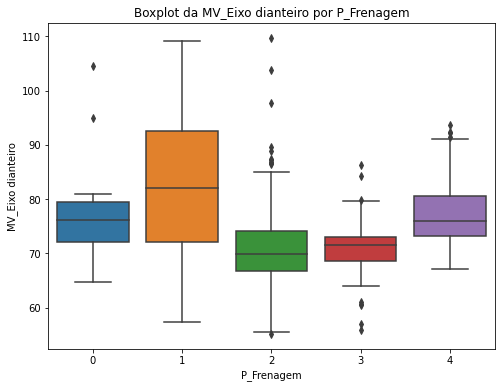

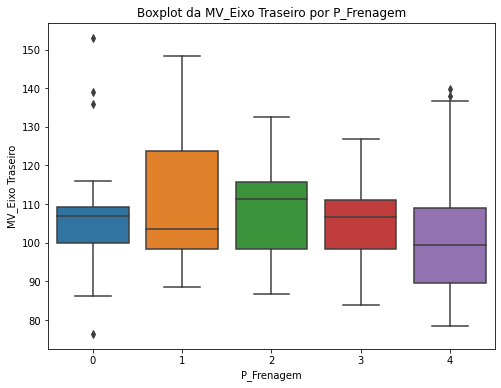

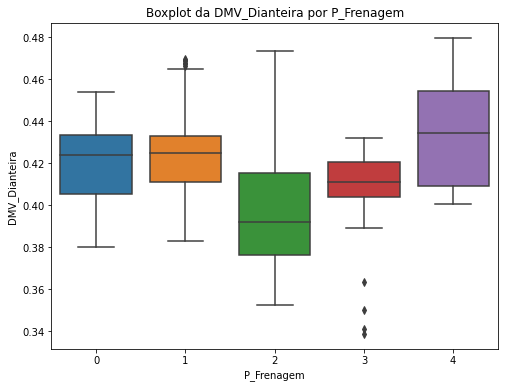

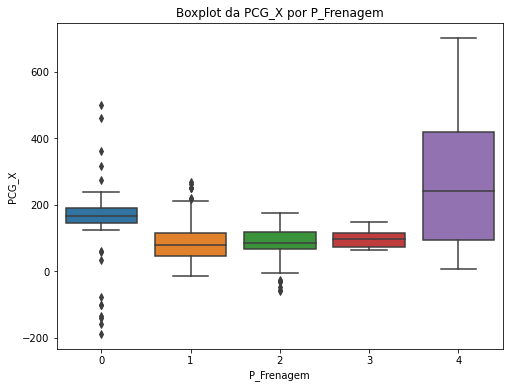

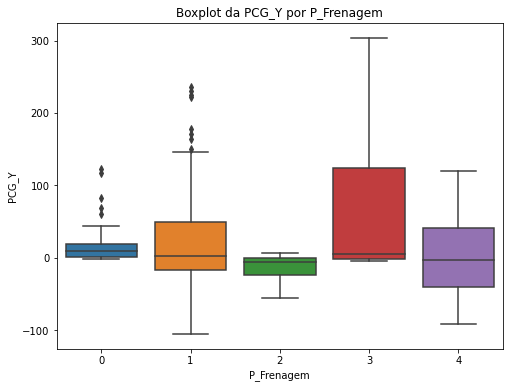

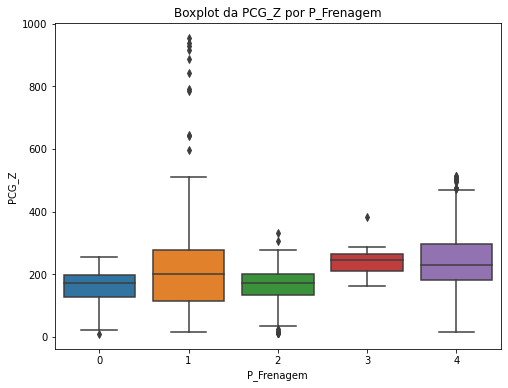

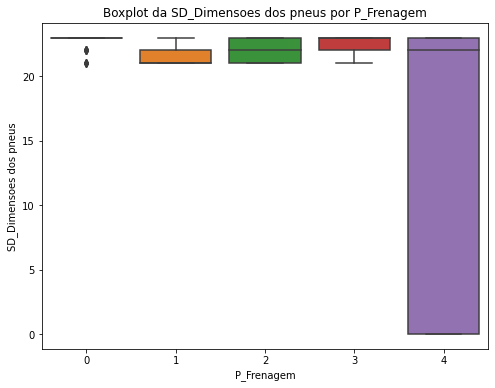

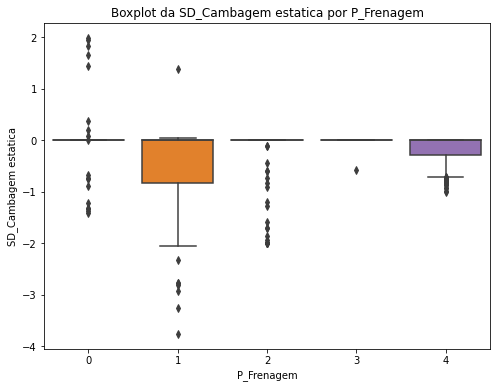

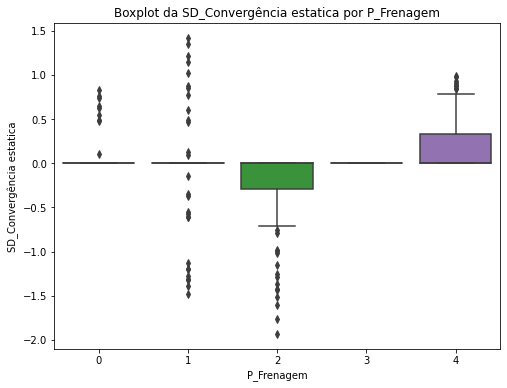

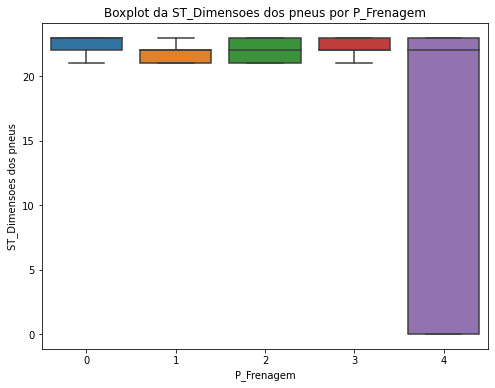

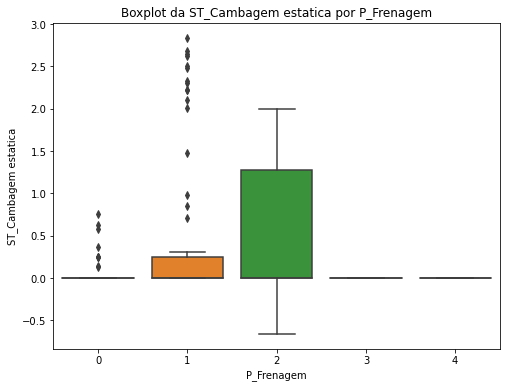

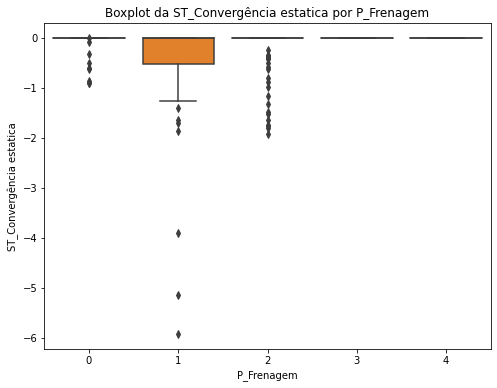

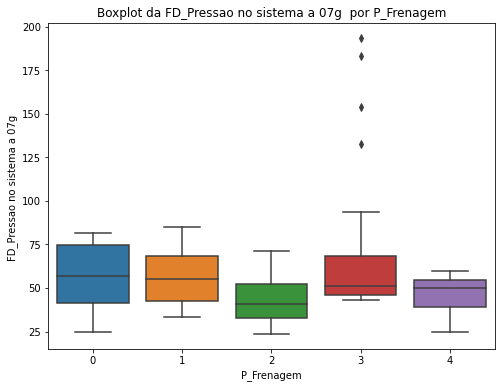

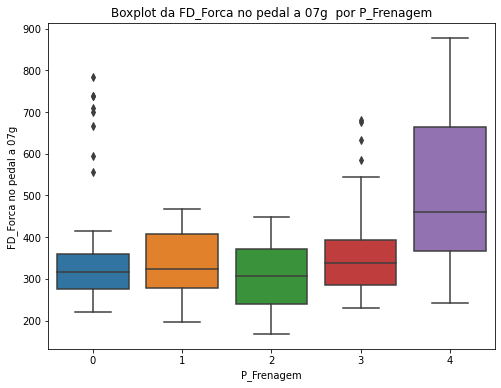

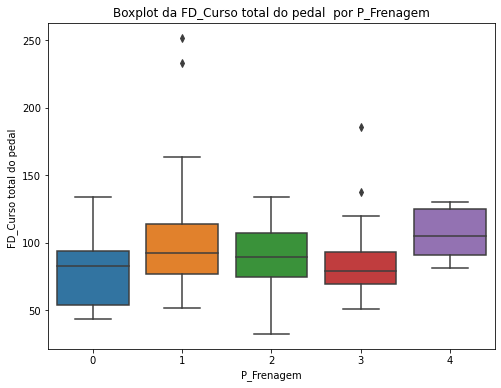

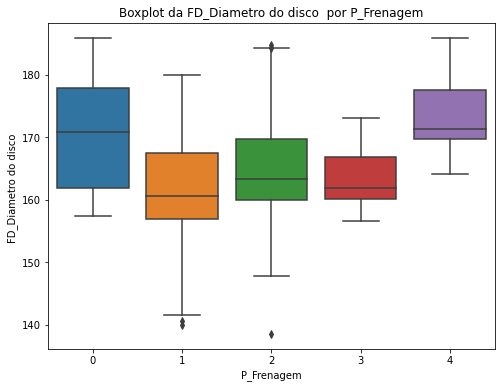

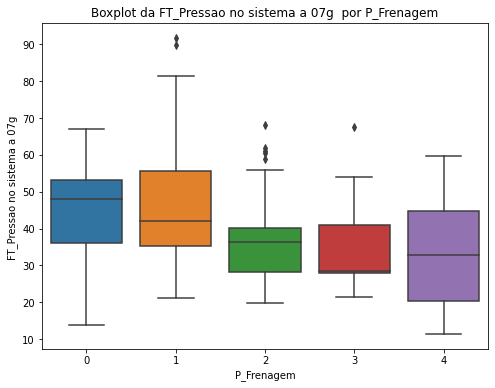

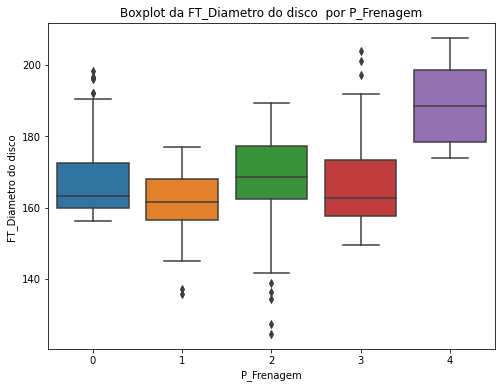

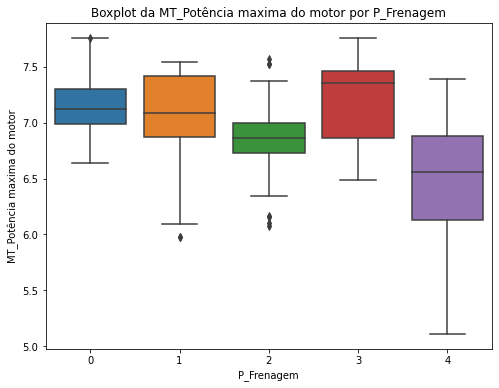

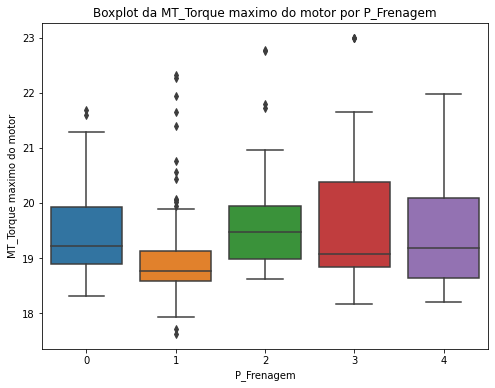

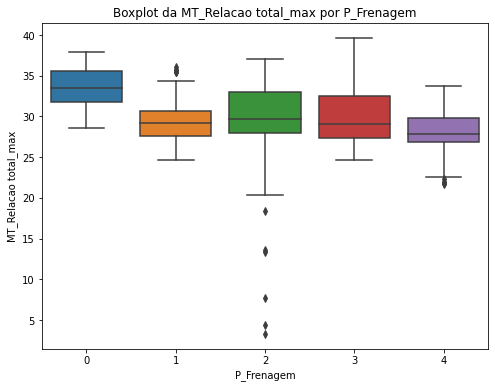

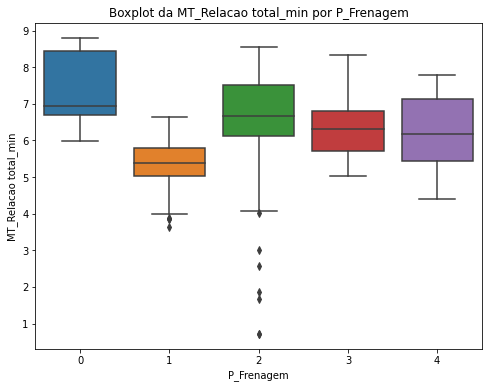

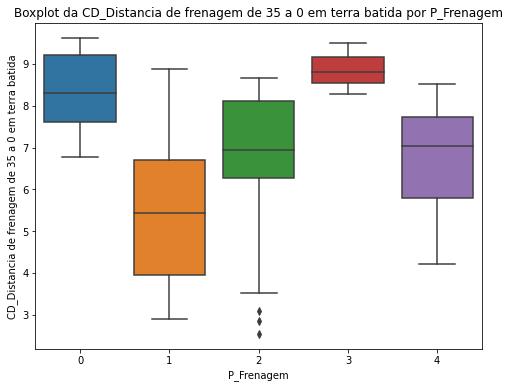

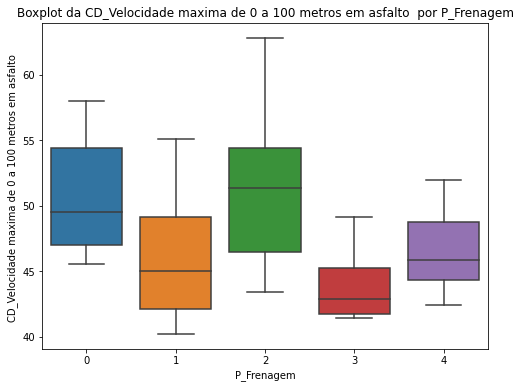

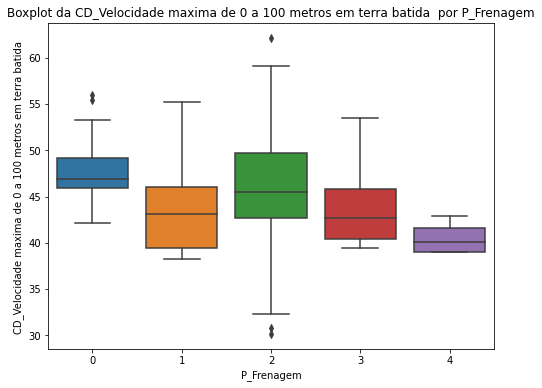

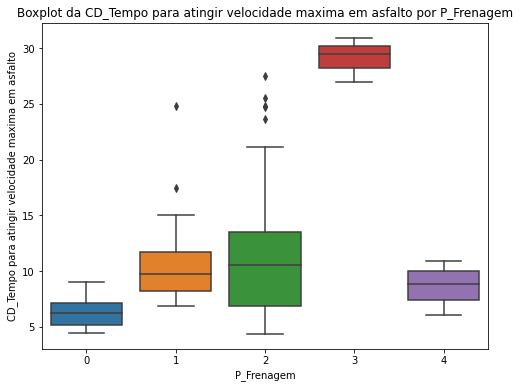

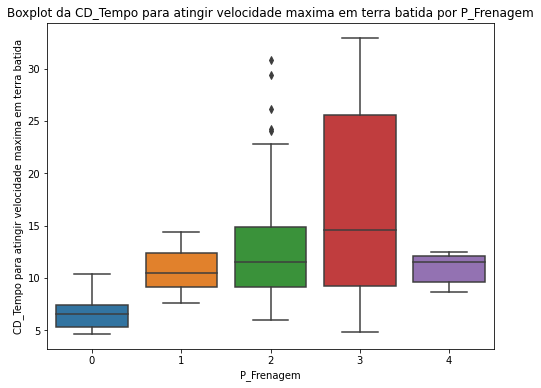

In [26]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Frenagem':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Frenagem', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Frenagem')
        plt.ylabel(coluna)
        plt.xlabel('P_Frenagem')
        plt.show()

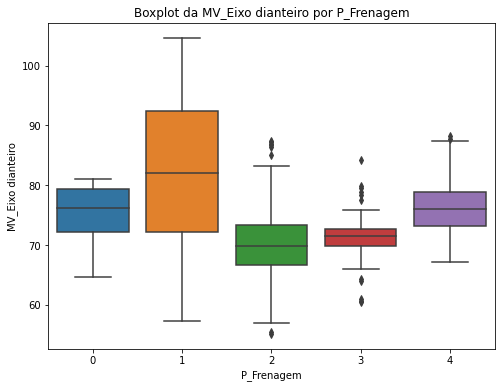

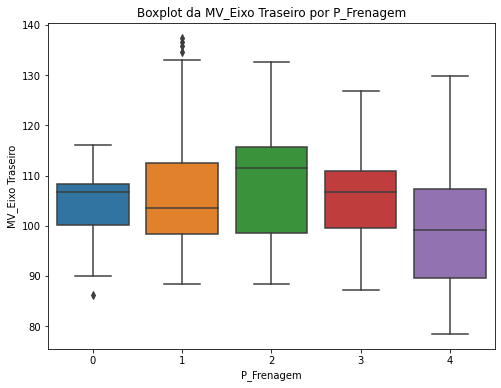

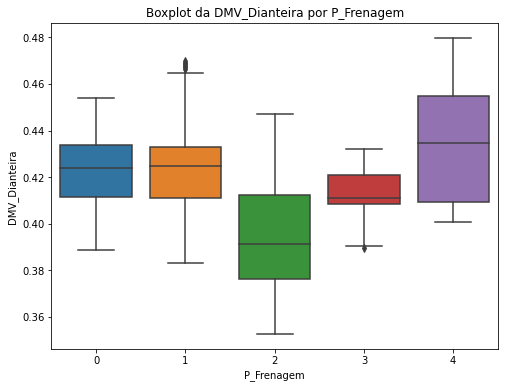

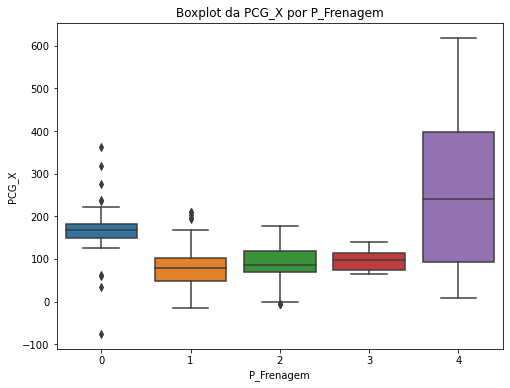

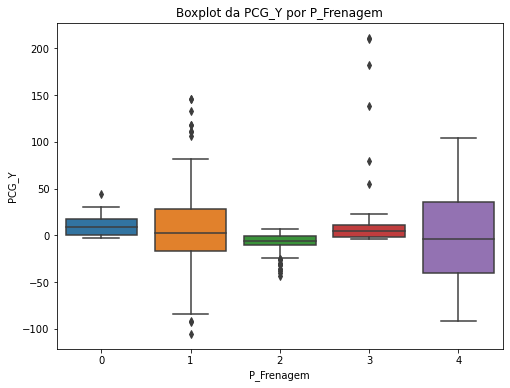

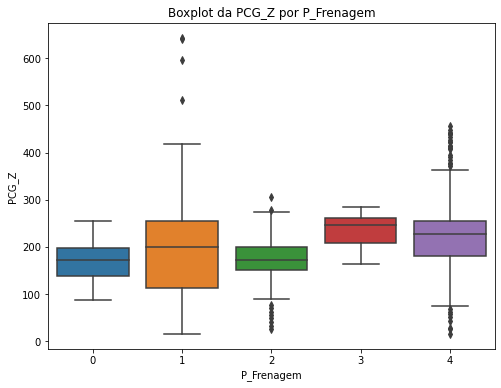

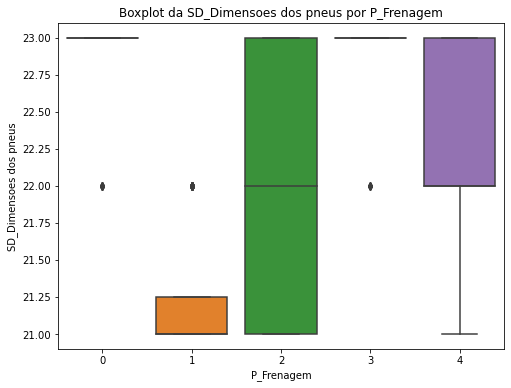

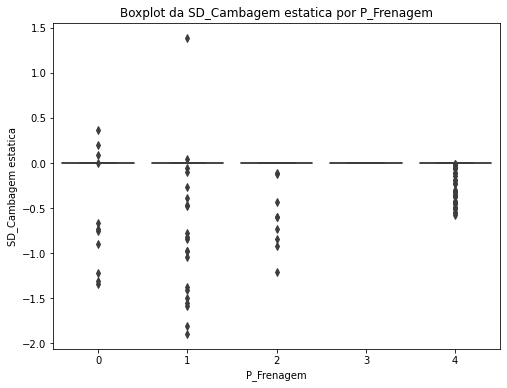

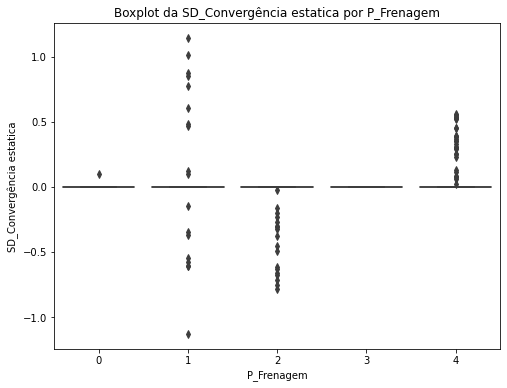

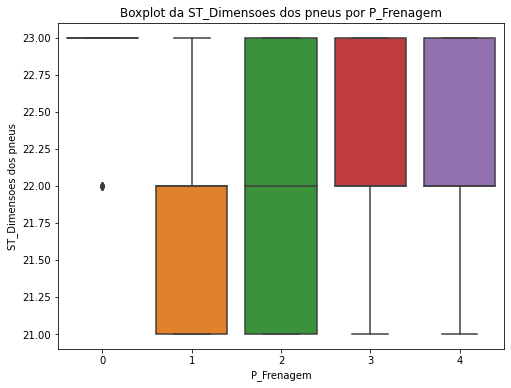

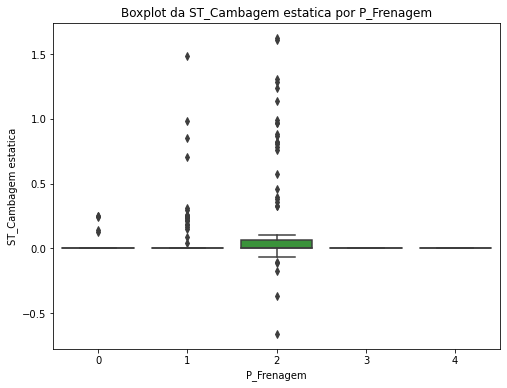

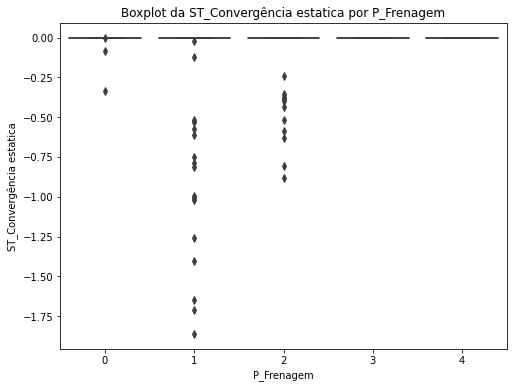

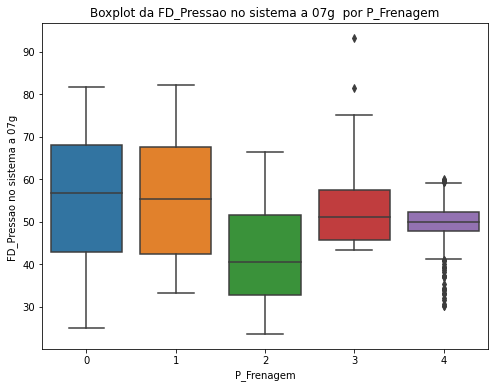

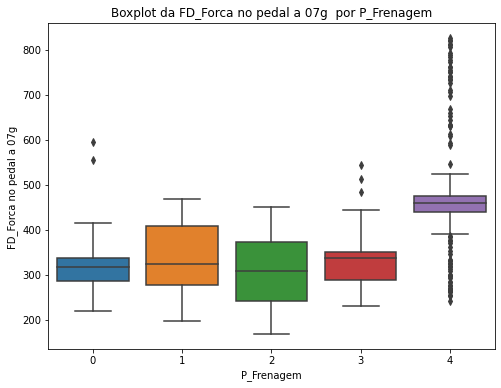

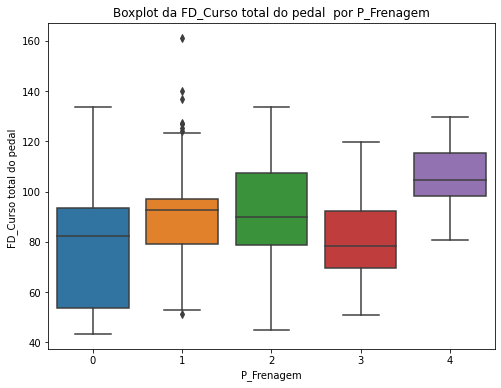

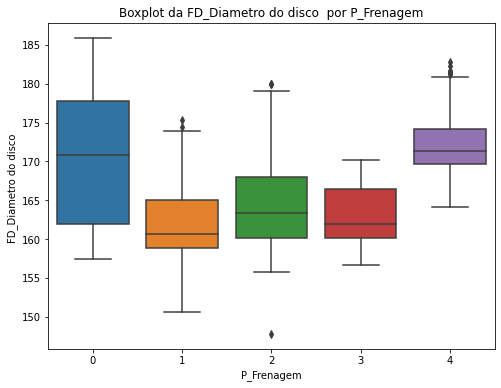

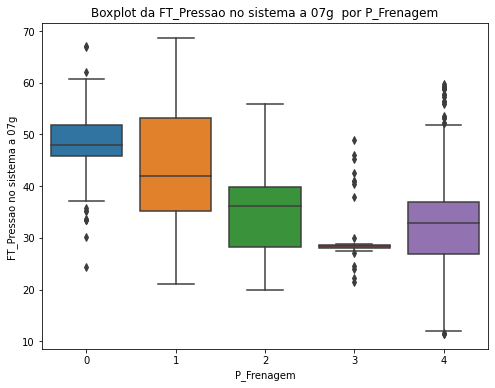

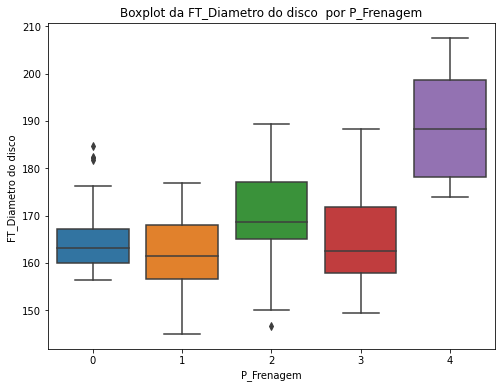

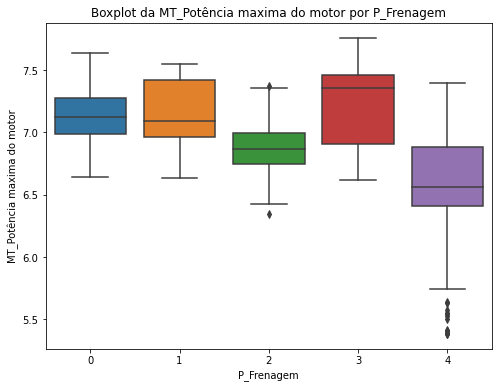

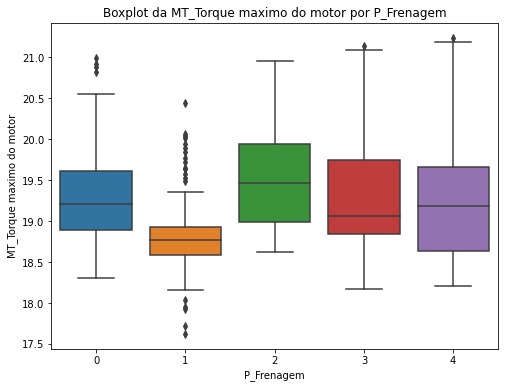

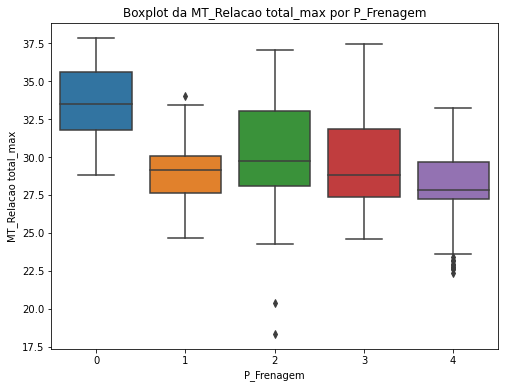

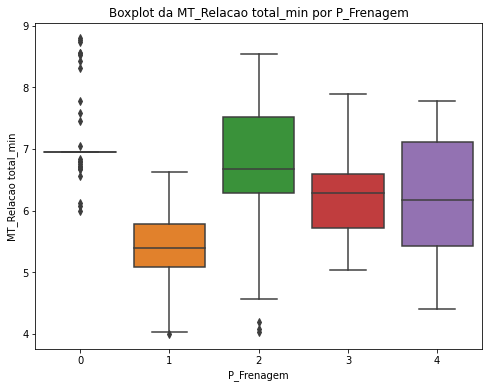

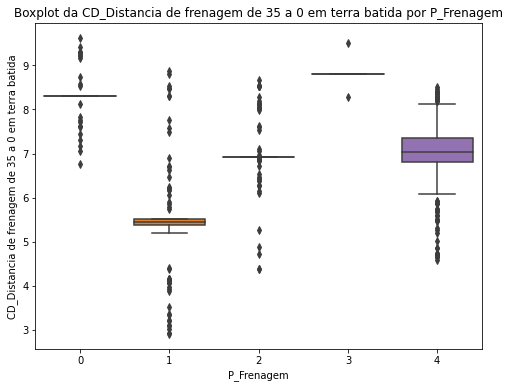

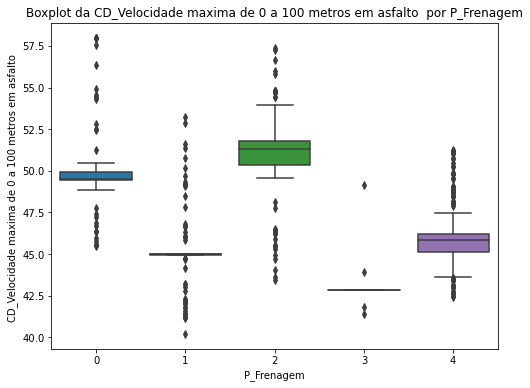

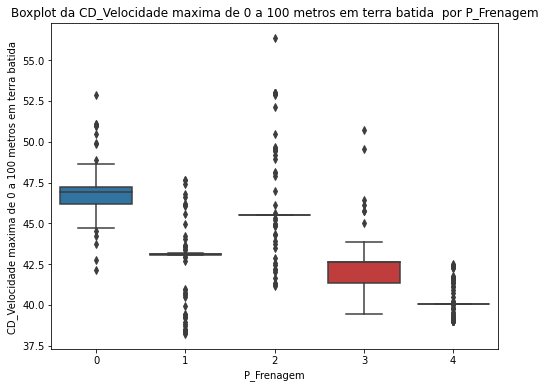

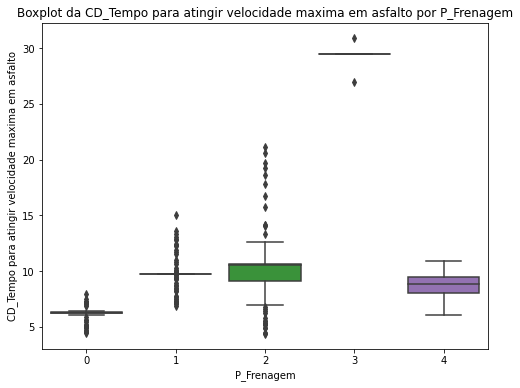

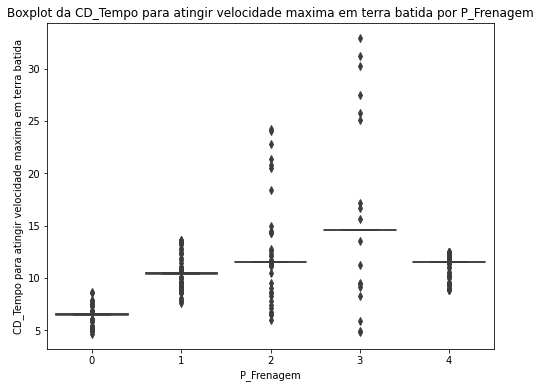

In [28]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Frenagem':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Frenagem', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Frenagem')
        plt.ylabel(coluna)
        plt.xlabel('P_Frenagem')
        plt.show()

In [27]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Frenagem']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Frenagem'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Frenagem'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Frenagem'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

In [29]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [39]:
data_corr = df.drop(['P_Frenagem'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

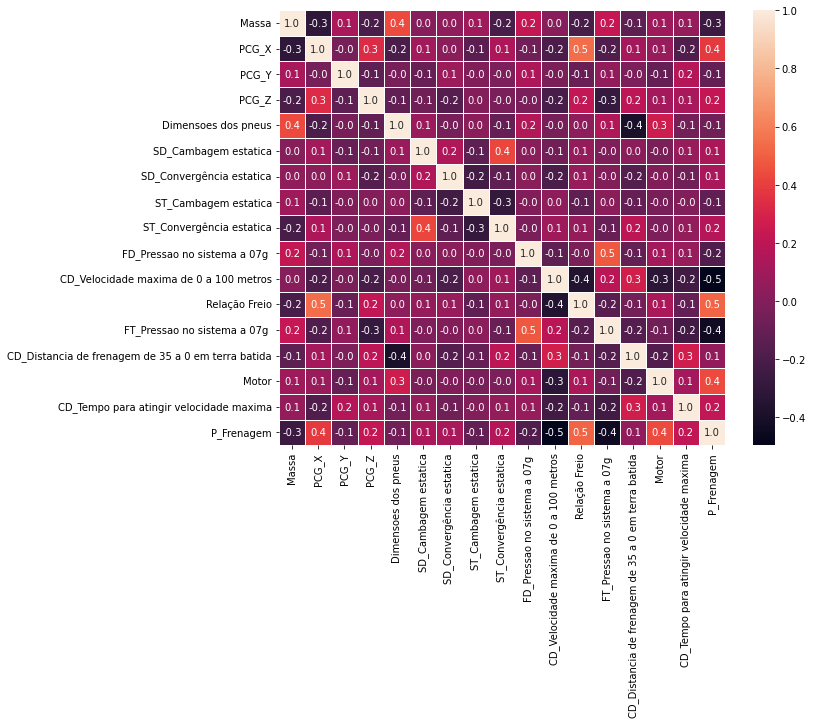

In [41]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [32]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro', 'DMV_Dianteira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
    'DMV_Dianteira'
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 0

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  SD_Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807                    23.0   
1    -9.212629  146.564530  -1.527800  156.983505                    23.0   
3   -19.953658  138.942674  -2.378915  171.803902                    23.0   
6     4.918699  144.971225  -0.755963  207.732041                    22.0   
7     2.485401  152.798073  -1.091099  186.515311                    23.0   
..         ...         ...        ...         ...                     ...   
995  16.473140  469.079250 -19.065627  375.904823                    22.0   
996  -9.783527  476.084678  41.995148  347.650532                    22.0   
997  -1.712409  240.789886  42.902184  288.451592                    22.0   
998 -12.856975   28.334621 -28.890856  232.174079                    22.0   
999  17.690496  134.053421 -41.797470  226.836990                    22.0   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Dimensoes dos pneus

In [43]:
# Aplicar PCA para reduzir variáveis de alta correlação - Relação Freio
variaveis_reduzidas = df[['FD_Forca no pedal a 07g ', 'FD_Curso total do pedal ', 'FD_Diametro do disco ','FT_Diametro do disco ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Diametro do disco '
    
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 11

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Relação Freio', variavel_reduzida)

print(df)

KeyError: "None of [Index(['FD_Forca no pedal a 07g ', 'FD_Curso total do pedal ',\n       'FD_Diametro do disco ', 'FT_Diametro do disco '],\n      dtype='object')] are in the [columns]"

In [44]:
# Aplicar PCA para reduzir variáveis de alta correlação - F_Pressao
variaveis_reduzidas = df[['FT_Pressao no sistema a 07g ', 'FD_Pressao no sistema a 07g ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'FT_Pressao no sistema a 07g ',
    'FD_Pressao no sistema a 07g ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 11

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'F_Pressao no sistema', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807            -1.233453   
1    -9.212629  146.564530  -1.527800  156.983505            -1.233453   
3   -19.953658  138.942674  -2.378915  171.803902            -1.233453   
6     4.918699  144.971225  -0.755963  207.732041             0.180511   
7     2.485401  152.798073  -1.091099  186.515311            -1.233453   
..         ...         ...        ...         ...                  ...   
995  16.473140  469.079250 -19.065627  375.904823             0.180511   
996  -9.783527  476.084678  41.995148  347.650532             0.180511   
997  -1.712409  240.789886  42.902184  288.451592             0.180511   
998 -12.856975   28.334621 -28.890856  232.174079             0.180511   
999  17.690496  134.053421 -41.797470  226.836990             0.180511   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Cambagem estatica  \
0                0.000000         

In [34]:
# Aplicar PCA para reduzir variáveis de alta correlação - Velocidade maxima de 0 a 100 metros
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em asfalto ', 'CD_Velocidade maxima de 0 a 100 metros em terra batida ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 18

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade maxima de 0 a 100 metros', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  SD_Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807                    23.0   
1    -9.212629  146.564530  -1.527800  156.983505                    23.0   
3   -19.953658  138.942674  -2.378915  171.803902                    23.0   
6     4.918699  144.971225  -0.755963  207.732041                    22.0   
7     2.485401  152.798073  -1.091099  186.515311                    23.0   
..         ...         ...        ...         ...                     ...   
995  16.473140  469.079250 -19.065627  375.904823                    22.0   
996  -9.783527  476.084678  41.995148  347.650532                    22.0   
997  -1.712409  240.789886  42.902184  288.451592                    22.0   
998 -12.856975   28.334621 -28.890856  232.174079                    22.0   
999  17.690496  134.053421 -41.797470  226.836990                    22.0   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Dimensoes dos pneus

In [35]:
# Aplicar PCA para reduzir variáveis de alta correlação - Relação Freio
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',    
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 19

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  SD_Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807                    23.0   
1    -9.212629  146.564530  -1.527800  156.983505                    23.0   
3   -19.953658  138.942674  -2.378915  171.803902                    23.0   
6     4.918699  144.971225  -0.755963  207.732041                    22.0   
7     2.485401  152.798073  -1.091099  186.515311                    23.0   
..         ...         ...        ...         ...                     ...   
995  16.473140  469.079250 -19.065627  375.904823                    22.0   
996  -9.783527  476.084678  41.995148  347.650532                    22.0   
997  -1.712409  240.789886  42.902184  288.451592                    22.0   
998 -12.856975   28.334621 -28.890856  232.174079                    22.0   
999  17.690496  134.053421 -41.797470  226.836990                    22.0   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Dimensoes dos pneus

In [36]:
# Aplicar PCA para reduzir variáveis de alta correlação - Dimensoes dos pneus
variaveis_reduzidas = df[['SD_Dimensoes dos pneus', 'ST_Dimensoes dos pneus']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'SD_Dimensoes dos pneus',
    'ST_Dimensoes dos pneus',    
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 4

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Dimensoes dos pneus', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807            -1.233453   
1    -9.212629  146.564530  -1.527800  156.983505            -1.233453   
3   -19.953658  138.942674  -2.378915  171.803902            -1.233453   
6     4.918699  144.971225  -0.755963  207.732041             0.180511   
7     2.485401  152.798073  -1.091099  186.515311            -1.233453   
..         ...         ...        ...         ...                  ...   
995  16.473140  469.079250 -19.065627  375.904823             0.180511   
996  -9.783527  476.084678  41.995148  347.650532             0.180511   
997  -1.712409  240.789886  42.902184  288.451592             0.180511   
998 -12.856975   28.334621 -28.890856  232.174079             0.180511   
999  17.690496  134.053421 -41.797470  226.836990             0.180511   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Cambagem estatica  \
0                0.000000         

In [37]:
# Aplicar PCA para reduzir variáveis de alta correlação - Motor
variaveis_reduzidas = df[['MT_Potência maxima do motor', 'MT_Torque maximo do motor','MT_Relacao total_max', 'MT_Relacao total_min']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor', 
    'MT_Relacao total_max',
    'MT_Relacao total_min'
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 14

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Motor', variavel_reduzida)

print(df)

         Massa       PCG_X      PCG_Y       PCG_Z  Dimensoes dos pneus  \
0     0.936874  191.073547   0.723952  255.569807            -1.233453   
1    -9.212629  146.564530  -1.527800  156.983505            -1.233453   
3   -19.953658  138.942674  -2.378915  171.803902            -1.233453   
6     4.918699  144.971225  -0.755963  207.732041             0.180511   
7     2.485401  152.798073  -1.091099  186.515311            -1.233453   
..         ...         ...        ...         ...                  ...   
995  16.473140  469.079250 -19.065627  375.904823             0.180511   
996  -9.783527  476.084678  41.995148  347.650532             0.180511   
997  -1.712409  240.789886  42.902184  288.451592             0.180511   
998 -12.856975   28.334621 -28.890856  232.174079             0.180511   
999  17.690496  134.053421 -41.797470  226.836990             0.180511   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Cambagem estatica  \
0                0.000000         

In [45]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

         Massa       PCG_X      PCG_Y       PCG_Z  Dimensoes dos pneus  \
833  -5.823657  240.789886  38.798946  227.805690            -0.539775   
597   8.054058  119.096612  -2.332423  164.760006             0.153902   
885 -15.286420  411.685803 -84.563551  440.824827             0.874188   
874   3.760610   64.875873  23.931540  224.064881             0.153902   
94    6.958361  204.173375   6.548659  185.513553             0.180511   
..         ...         ...        ...         ...                  ...   
923   8.584922  224.601186  47.164565  181.277808             0.180511   
494  12.172739  122.531351 -39.985921  142.608702             0.153902   
437  -7.775827   52.631767   5.325778  173.211713            -1.233453   
487 -17.093225   82.951891   6.710215  182.246361            -1.233453   
452   6.435745  113.988389  -6.711478  241.036964             1.594474   

     SD_Cambagem estatica  SD_Convergência estatica  ST_Cambagem estatica  \
833              0.000000         

# Escolha do Modelo

## Regressão Logística:

In [46]:
# Modelo de regressão logística.
model_LR = LogisticRegression()
model_LR.fit(X_treino, Y_treino)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [47]:
# Avaliação do desempenho do modelo.
Y_pred = model_LR.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão Logística:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão Logística:
Acurácia: 0.81
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.63      0.57      0.60        30
           2       0.84      0.81      0.82        26
           3       1.00      1.00      1.00        12
           4       0.86      0.90      0.88        61

    accuracy                           0.81       144
   macro avg       0.80      0.80      0.80       144
weighted avg       0.80      0.81      0.80       144



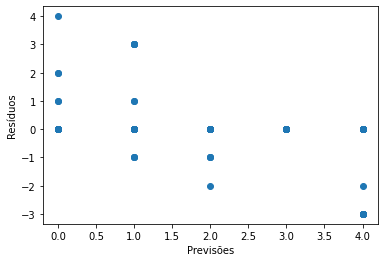

In [48]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Máquinas de Vetores de Suporte (SVM)

In [49]:
# Modelo SVM com um kernel linear e "um contra todos"
model_SVM = SVC(kernel='linear', decision_function_shape='ovr')
model_SVM.fit(X_treino, Y_treino)

SVC(kernel='linear')

In [50]:
# Avaliação do desempenho do modelo.
Y_pred = model_SVM.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Máquinas de Vetores de Suporte:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Máquinas de Vetores de Suporte:
Acurácia: 0.90
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.74      0.83      0.78        30
           2       0.91      0.81      0.86        26
           3       1.00      1.00      1.00        12
           4       0.95      0.92      0.93        61

    accuracy                           0.90       144
   macro avg       0.91      0.91      0.91       144
weighted avg       0.90      0.90      0.90       144



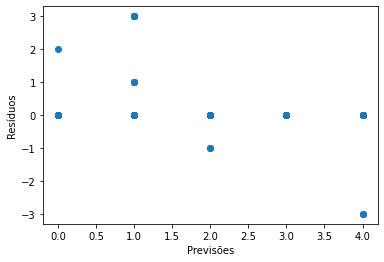

In [51]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## K-Nearest Neighbors

In [52]:
k = 3  # Número de vizinhos (Altere por necessidade)

# Modelo de K-Vizinhos Mais Próximos (K-Nearest Neighbors - KNN).
model_KNN = KNeighborsClassifier(n_neighbors=k)
model_KNN.fit(X_treino, Y_treino)

KNeighborsClassifier(n_neighbors=3)

In [53]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_KNN.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para K-Vizinhos Mais Próximos:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para K-Vizinhos Mais Próximos:
Acurácia: 0.83
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        15
           1       0.91      0.67      0.77        30
           2       0.77      0.88      0.82        26
           3       0.73      0.67      0.70        12
           4       0.91      0.87      0.89        61

    accuracy                           0.83       144
   macro avg       0.79      0.82      0.79       144
weighted avg       0.84      0.83      0.83       144



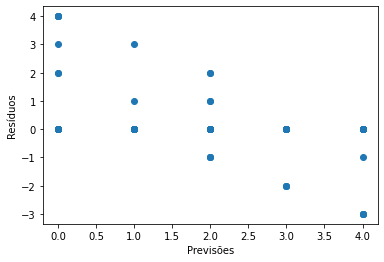

In [54]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Decision Tree Classifier

In [55]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

In [56]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_DTC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Árvore de Decisão de Classificação:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Árvore de Decisão de Classificação:
Acurácia: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.90      0.92        30
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        12
           4       0.95      0.97      0.96        61

    accuracy                           0.97       144
   macro avg       0.98      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



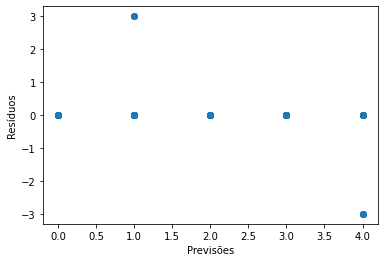

In [57]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Random Forest Classifier

In [58]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

In [59]:
# Avaliação do desempenho do modelo.
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão de Floresta Aleatória:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão de Floresta Aleatória:
Acurácia: 0.99
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.97      1.00      0.98        30
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        61

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



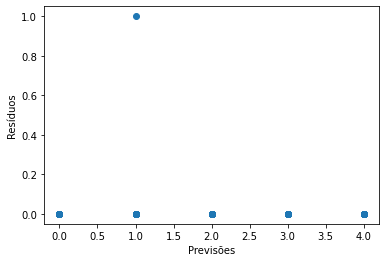

In [60]:
# Analisar os resíduos.
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## XGBoost

In [62]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [63]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.99
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        30
           2       1.00      0.96      0.98        26
           3       1.00      1.00      1.00        12
           4       1.00      0.98      0.99        61

    accuracy                           0.99       144
   macro avg       0.99      0.99      0.99       144
weighted avg       0.99      0.99      0.99       144



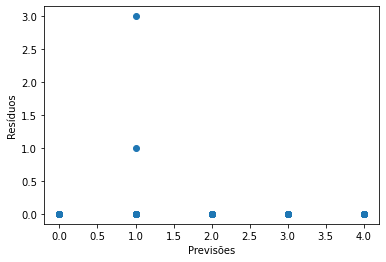

In [64]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

# Treinamento do Modelo

## Bootstraps

In [88]:
n_iterations = 100  # Número de iterações do Bootstrap

# Lista para armazenar as métricas de desempenho em cada iteração
performance_metrics = []

for _ in range(n_iterations):
    # Amostragem Bootstrap: crie um conjunto de treinamento com reamostragem
    indices_amostra = np.random.choice(len(X_treino), size=len(X_treino), replace=True)
    X_bootstrap = X_treino.iloc[indices_amostra]  
    y_bootstrap = Y_treino.iloc[indices_amostra]

    # Crie e treine seu modelo
    model_RFC.fit(X_bootstrap, y_bootstrap)

    # Avalie o modelo no conjunto de teste
    desempenho = model_RFC.score(X_teste, Y_teste)  # Mede a acurácia
    performance_metrics.append(desempenho)

In [89]:
# Calcule as métricas resumidas (por exemplo, média e desvio padrão)
media_desempenho = np.mean(performance_metrics)
desvio_padrao_desempenho = np.std(performance_metrics)

# Imprima as métricas resumidas
print(f'Média do desempenho: {media_desempenho:.4f}')
print(f'Desvio Padrão do desempenho: {desvio_padrao_desempenho:.4f}')

Média do desempenho: 0.9664
Desvio Padrão do desempenho: 0.0153


# Avaliação do Modelo

## Cross-Validation

In [68]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#kfold = StratifiedKFold(n_splits = 5, shuffle = True) # Caso uma classe prevaleça muita em função da outra

In [70]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 96.72%
Intervalo de acurácia: [93.79% ~ 99.64%]


In [71]:
# Calcule a média das pontuações para avaliação de Precisão do modelo
def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean * 100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='precision_macro') # Checar Modelo
intervalo_prec(scores)

Precisão média: 97.43%
Intervalo de Precisão: [94.59% ~ 100.28%]


In [72]:
# Calcule a média das pontuações para avaliação de Recall do modelo
def intervalo_recall(results):
    mean = results.mean()
    dv = results.std()
    print('Recall médio: {:.2f}%'.format(mean * 100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='recall_macro') # Checar Modelo
intervalo_recall(scores)

Recall médio: 96.70%
Intervalo de Recall: [95.44% ~ 97.95%]


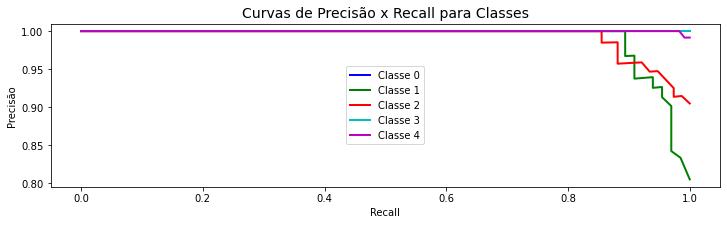

In [73]:
# Comparar scores de Previsão e Recall
# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

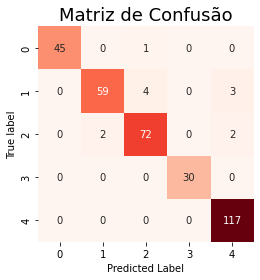

In [74]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [75]:
# Relatório do modelo
print('Relatório de classificação:\n', classification_report(Y_treino, Y_pred, digits=4))

Relatório de classificação:
               precision    recall  f1-score   support

           0     1.0000    0.9783    0.9890        46
           1     0.9672    0.8939    0.9291        66
           2     0.9351    0.9474    0.9412        76
           3     1.0000    1.0000    1.0000        30
           4     0.9590    1.0000    0.9791       117

    accuracy                         0.9642       335
   macro avg     0.9723    0.9639    0.9677       335
weighted avg     0.9645    0.9642    0.9639       335



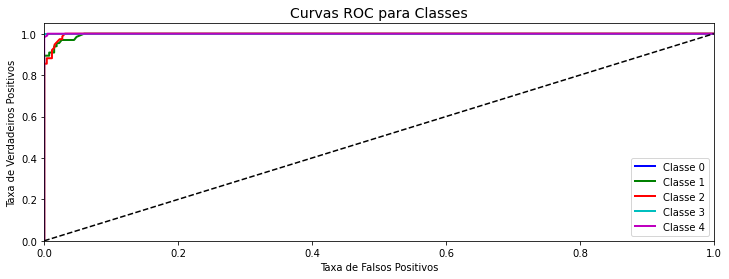

In [76]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para Classes', fontsize=14)
plt.show()

In [78]:
# Área sob a Curva
print('Área sob a curva ROC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

Área sob a curva ROC: 0.9990


In [79]:
# Treinamento do modelo 
model_RFC.fit(X_treino, Y_treino) # Checar modelo

# Fazer previsões no conjunto de teste
Y_pred_teste = model_XGB.predict(X_teste)

# Acurácia no conjunto de teste
accuracy = accuracy_score(Y_teste, Y_pred_teste)
print('Acurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

# Precisão no conjunto de teste
precision = precision_score(Y_teste, Y_pred_teste, average='macro')
print('Precisão no conjunto de teste: {:.2f}%'.format(precision * 100))

# Recall no conjunto de teste
recall = recall_score(Y_teste, Y_pred_teste, average='macro')
print('Recall no conjunto de teste: {:.2f}%'.format(recall * 100))

# Relatório de classificação no conjunto de teste
print('Relatório de classificação no conjunto de teste:\n', classification_report(Y_teste, Y_pred_teste, digits=4))

Acurácia no conjunto de teste: 98.61%
Precisão no conjunto de teste: 98.75%
Recall no conjunto de teste: 98.90%
Relatório de classificação no conjunto de teste:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        15
           1     0.9375    1.0000    0.9677        30
           2     1.0000    0.9615    0.9804        26
           3     1.0000    1.0000    1.0000        12
           4     1.0000    0.9836    0.9917        61

    accuracy                         0.9861       144
   macro avg     0.9875    0.9890    0.9880       144
weighted avg     0.9870    0.9861    0.9862       144



## Análise de Variáveis 

In [80]:
# Analisar variáveis que mais afetam o modelo
importances = model_RFC.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.03262238 0.09163821 0.05274163 0.03189955 0.05112853 0.01002307
 0.00994756 0.01142135 0.0051201  0.16757022 0.12542927 0.03554043
 0.15923501 0.06763491 0.14804778]


<Figure size 1440x1152 with 0 Axes>

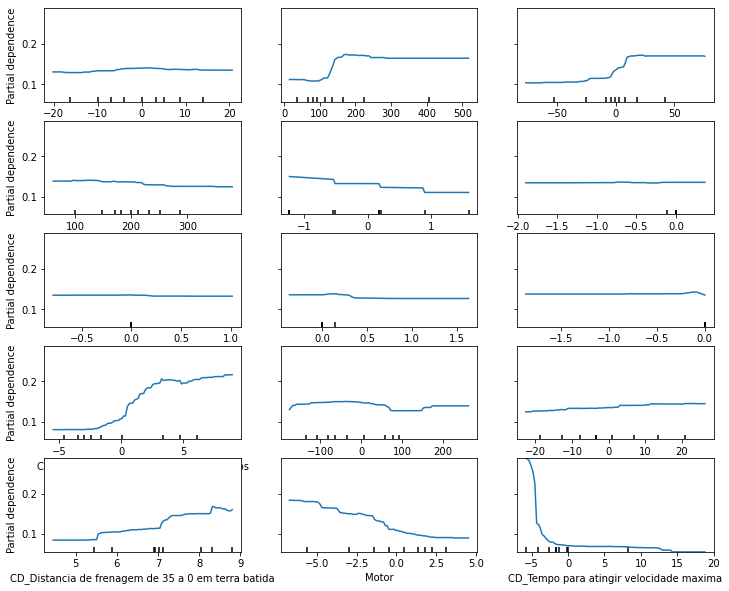

In [82]:
# Analisar como uma variável afeta as previsões
colunas = df.columns[:-1].tolist() # Separar as variáveis

plt.figure(figsize=(20, 16))

# Crie PDPs para as variáveis escolhidas
plot_partial_dependence(model_RFC, X_treino, features=colunas, target=Y_treino.all(), grid_resolution=100)

# Obter a figura atual e definir o tamanho
fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.show()

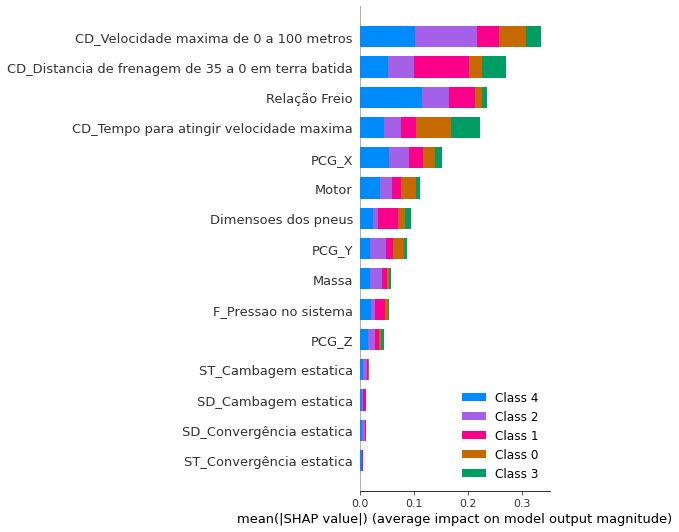

In [83]:
# Crie um objeto explainer
explainer = shap.Explainer(model_RFC, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Aprimoramento de Parâmetros

## Tuning

In [84]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [85]:
# Guardar os parâmetros enconntrados fora do código
melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_fre.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_fre.pkl')

['melhores_parametros_fre.pkl']

In [86]:
# Ajustar um modelo de RandomForestRegressor
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=30)

In [87]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.96      0.90      0.93        30
           2       0.93      0.96      0.94        26
           3       1.00      1.00      1.00        12
           4       0.98      1.00      0.99        61

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144



## Redução de Dimensão

In [ ]:
# Selecione um número específico de características mais importantes
num_caracteristicas_selecionadas = 3  # Por exemplo, selecione as 3 mais importantes

X_treino_selecionado = X_treino[:, indices_ordenados[:num_caracteristicas_selecionadas]]
X_teste_selecionado = X_teste[:, indices_ordenados[:num_caracteristicas_selecionadas]]

# Em seguida, treine seu modelo no conjunto de dados com características selecionadas
model_XGB.fit(X_treino_selecionado, Y_treino)

In [ ]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = np.array([6]).reshape(-1, 1) # Colocar os valores pedidos

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')